Test if L1 normalizing Largrange Multipliers improve SVM by reducing number of support vector 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from scipy.stats import bernoulli

from classification.classifier import SVM
from classification.optimizer import QpDuel

def rotation2D(theta, x):
    """ x: 2D array"""
    import math
    R = np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
    return R @ x

def mulall(x):
    v = 1
    for xi in x:
        v = v*xi
    return v

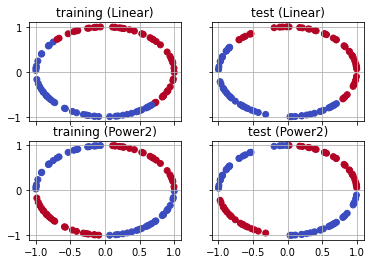

In [2]:
# generate data
num_data = 100
num_test = 100
theta = np.pi/3
d = 2
C = 1
error_rate = 0.0

# training data
X = np.random.rand(num_data, d)
X = X - np.mean(X, 0) # standarderize E[X]=0
X = np.array([x/np.linalg.norm(x) for x in X]) # normalize ||X||=1

# test data
Xtest = np.random.rand(num_data, d)
Xtest = Xtest - np.mean(Xtest, 0) # standarderize E[Xtest]=0
Xtest = np.array([xtest/np.linalg.norm(xtest) for xtest in Xtest]) # normalize ||Xtest||=1

# bit flip label error
err = (-1)**bernoulli.rvs(error_rate, loc=0, size=num_data)

# label for linear kernel
#y_linear = np.array([np.sign(x[0]) for x in rotation2D(theta, X.T).T])*err
y_linear = np.array([np.sign(np.mean(x)) for x in X])*err
#ytest_linear = np.array([np.sign(x[0]) for x in rotation2D(theta, Xtest.T).T])
ytest_linear = np.array([np.sign(np.mean(x)) for x in Xtest])

# label for power2 kernel
#y_power2 = np.array([np.sign(x[0])*np.sign(x[1]) for x in rotation2D(theta, X.T).T])*err
#ytest_power2 = np.array([np.sign(x[0])*np.sign(x[1]) for x in rotation2D(theta, Xtest.T).T])
y_power2 = np.array([np.sign(mulall(x)) for x in X])*err
ytest_power2 = np.array([np.sign(mulall(x)) for x in Xtest])

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.flatten()
data = [X, Xtest, X, Xtest]
label = [y_linear, ytest_linear, y_power2, ytest_power2]
subtitle = ['training (Linear)', 'test (Linear)','training (Power2)','test (Power2)']
for i in range(len(ax)):
    ax[i].scatter(data[i][:,0], data[i][:,1], c=label[i], cmap=plt.cm.coolwarm)
    ax[i].grid()
    ax[i].set_title(subtitle[i])

In [3]:
linker = lambda X, Y: X@Y.T
cls_lin = SVM(X, y_linear, kernel= linker, name='linear kernel')
cls_lin_n = SVM(X, y_linear, kernel= linker, name='linear kernel (normalized)')
cls_lin.optimize(QpDuel, C=C, Probability=False)
cls_lin_n.optimize(QpDuel, C=C, Probability=True)

cls_pw2 = SVM(X, y_power2, kernel= 'power2', name='power2 kernel')
cls_pw2_n = SVM(X, y_power2, kernel= 'power2', name='power2 kernel (normalized)')
cls_pw2.optimize(QpDuel, C=C, Probability=False)
cls_pw2_n.optimize(QpDuel, C=C, Probability=True)

     pcost       dcost       gap    pres   dres
 0: -2.1844e+01 -1.5190e+02  6e+02  2e+00  9e-16
 1: -1.4564e+01 -7.3796e+01  8e+01  1e-01  9e-16
 2: -1.4374e+01 -2.2445e+01  9e+00  1e-02  2e-15
 3: -1.6457e+01 -1.8875e+01  3e+00  3e-03  1e-15
 4: -1.7159e+01 -1.7708e+01  6e-01  3e-04  1e-15
 5: -1.7366e+01 -1.7415e+01  5e-02  9e-06  1e-15
 6: -1.7386e+01 -1.7389e+01  3e-03  5e-07  9e-16
 7: -1.7387e+01 -1.7388e+01  3e-05  5e-09  1e-15
 8: -1.7387e+01 -1.7387e+01  3e-07  5e-11  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9513e-01 -1.0389e+02  4e+02  1e+00  4e-16
 1: -9.7604e-01 -2.9934e+01  3e+01  2e-02  6e-16
 2: -9.1401e-01 -1.8818e+00  1e+00  2e-04  6e-16
 3: -9.4111e-01 -1.1039e+00  2e-01  3e-05  4e-16
 4: -9.8647e-01 -1.0496e+00  6e-02  2e-16  4e-16
 5: -9.9591e-01 -1.0044e+00  8e-03  2e-16  4e-16
 6: -9.9866e-01 -1.0002e+00  2e-03  5e-16  4e-16
 7: -9.9942e-01 -9.9957e-01  1e-04  2e-16  4e-16
 8: -9.9953e-01 -9.9953e-01  3e-06  2e-16  4e-1

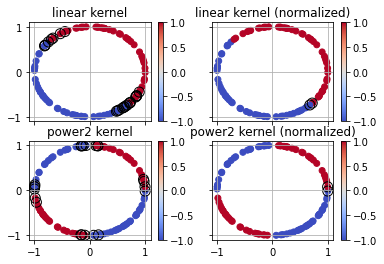

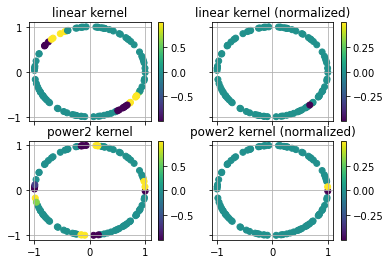

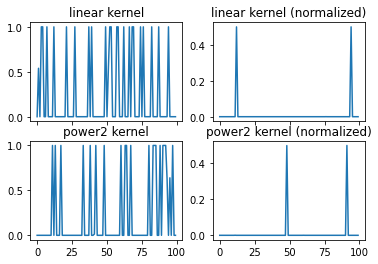

In [4]:
compare_linAndpower2_Normalized_sv, ax = plt.subplots(2,2, sharex=True, sharey=True)
clses = [cls_lin, cls_lin_n, cls_pw2, cls_pw2_n]
ax=ax.flatten()
for i in range(len(ax)):
    clses[i].plot(ax[i], sv=True)

compare_linAndpower2_Normalized_, ax = plt.subplots(2,2, sharex=True, sharey=True)
clses = [cls_lin, cls_lin_n, cls_pw2, cls_pw2_n]
ax=ax.flatten()
for i in range(len(ax)):
    clses[i].plot(ax[i], sv=False)

compare_linAndpower2_Normalized_alpha, ax = plt.subplots(2,2, sharex=True, sharey=False)
clses = [cls_lin, cls_lin_n, cls_pw2, cls_pw2_n]
ax=ax.flatten()
for i in range(len(ax)):
    ax[i].plot(clses[i].alpha)
    ax[i].set_title(clses[i].name)

In [5]:
clses = [cls_lin, cls_lin_n, cls_pw2, cls_pw2_n]
test_label = [ytest_linear, ytest_linear, ytest_power2, ytest_power2]
for i in range(len(clses)):
    print('Performance of', clses[i].name, 'is', clses[i].check_perfomance(Xtest, test_label[i]))

Performance of linear kernel is 0.98
Performance of linear kernel (normalized) is 0.98
Performance of power2 kernel is 0.99
Performance of power2 kernel (normalized) is 0.99
